# Baseball EDA
## Change all according info below

This file goes through an analytical pipeline of the Statcast baseball data collected from the `Data_Collection.ipynb` notebook. This file will detail a baseline performance using two methods: Logistic Regression and Decision Tree. These two models are specifically chosen for two main reasons: first is that they serve the role of "traditional models", and second is that they are, to an extent, interpretable. These two models, Logistic Regression and Decision Trees, will serve as a comparison in terms of performance and interpretability to models used in ***OTHER_NOTEBOOK***. The ultimate goal of this analytical project is utilize newer, more advanced modeling methods and extract knowledge with interpretation techniques. Thus, a benchmark needs to be established, both in terms of performance metrics (Accuracy, AUC, etc.) and interpretation power, in this case, coefficients and tree structure, to conclude that the proposed models and interpretation techniques do provide significant advantages over such traditional methods.

As such, the following will outline the process of this notebook. The main goals include: 
- Establish performance metrics for both models on raw data.
- Investigate interpretable aspects for both models. Explore the validity of such aspects
- Establish appropriate preprocessing steps to improve performance of models
- Re-evaluate models on processed data
- Investigate interpretable aspects on model built on processed data

## Outline of Notebook

Here is the outline of steps to be performed in this notebook.

1. Read in data.
    - Structure data as Pandas Dataframe
2. Ensure data quality
    - Investiate and remedy possible issues, such as missing data, poorly formatted data, data types, etc.
        - Check missing data
        - Check data types
        - Initial check on data values, see if any illogical values (for instance, 0mph for pitch speed)
3. Light Exploratory Data Analysis
    - Visualize data distributions, measures of central tendencies, correlations
        - Build Histograms
        - Build Box-plots
        - Scatter plots of interesting features noted in step 2
        - Build correlation matrix
        - Check target feature balance
        - Analysis of each
4. Establish initial baselines
    - Establish models with initial hyperparameters used in sci-kit learn library. Build training and testing split procedures, and train models on appropriate splits
        - If target value imbalance, balance out levels using simple oversampler
        - Instantiate models using scikit-learn library
        - Build cross-validation schema
        - Implement model with cross-validation schema
        - Show evaluation metrics: classification accuracy, f1 score, AUC
5. Interpret both models
    - Look into models more in depth
        - Logit Regression: show coefficients
        - Decision Tree: Visualize the tree in the notebook
        - Analyze both elements
6. Apply data preprocessing steps
    - Build data pipelines with preprocessing steps to improve results
        - Feature selection based on correlation analysis, statistical methods
        - Possible PCA
        - Data standardization
7. Re-Evaluate models 
    - Compare results of raw data pipeline with preprocessed data pipeline. For better performing pipeline:
        - run simple grid-search of hyperparameters to get best performance. 
        - Note: number of leaves on decision tree cannot be too large; we want to keep the ability to visualize and understand its decision rules.
        - re-evaluate results using grid-search best hyperparameters. 
        


## Begin Initial EDA

### Start with Data Input

In [1]:
#start with all dependencies

import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()

In [2]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv('Statcast_data.csv', index_col = 0)
    
    return baseball

baseball = load_data(data)

baseball.tail()

,player_name,p_throws,pitch_name,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,release_extension,description
128795,Ken Giles,R,4-Seam Fastball,96.8,2252.0,-2.0947,54.8756,6.1266,-0.5925,1.4848,3.5119,-140.7344,-5.5570,-8.4711,31.5861,-11.9222,3.4640,1.5896,5.624,ball
128796,Ken Giles,R,Slider,88.0,2316.0,-1.9062,56.1755,6.2282,0.2870,0.1921,7.9625,-127.3866,-4.9651,1.1966,27.3637,-29.4953,3.2302,1.5342,4.324,ball
128797,Ken Giles,R,4-Seam Fastball,95.9,2512.0,-1.8896,55.3921,6.4011,-0.8028,1.5344,7.4805,-139.0689,-10.6161,-11.5094,26.4429,-11.1119,3.4374,1.3679,5.106,called_strike
128798,Ken Giles,R,4-Seam Fastball,97.7,2400.0,-2.2301,55.0385,6.0804,-1.0659,1.3443,5.9860,-141.6711,-7.2205,-15.3199,35.5183,-13.2212,3.3353,1.6169,5.460,called_strike
128799,Ken Giles,R,Slider,86.0,2179.0,-1.9239,55.5515,6.1872,-0.0142,0.1733,3.7824,-124.7511,-5.4985,-0.9959,28.2202,-29.5437,3.2713,1.5507,4.951,ball


## Information regarding data REORDER FEATURES

As detailed in the `Data_Collection.ipynb` notebook, here is a review of the meaning of features within the datset. 

Note that the distance from home plate, where the batter stands, and the pitcher’s mound, where the pitcher throws, is 60 feet and 2 inches. 
- Release_speed: pitch velocity, reported out-of-hand.
- Release_pos_x: horizontal release position of the ball measured in feet from the catchers perspective.
- Release_pos_z: vertical release position of the ball measured in feet from the catchers perspective.
- Player_name: the name of the pitcher
- Description: description of the resulting pitch: ball, blocked_ball, called strike.
- P_throws: hand the pitcher throws with.
- Pfx_x: Horizontal movement in feet from the catcher’s perspective.
- Pfx_z: Vertical movement in feet from the catcher’s perspective.
- Vx0: the velocity of the pitch, measured in feet per second, in the x-dimension, determined at y=50 feet.
- Vy0: The velocity of the pitch, in feet per second, in the y-dimension, determined at y=50 feet.
- Vz0: the velocity of the pitch, in feet per second, in the z-dimension, determined at y=50 feet.
- ax: the acceleration of the pitch, in feet per second per second, in the x-dimension, determined at y=50 feet.
- ay:   the acceleration of the pitch, in feet per second per second, in the y-dimension, determined at y=50 feet.
- az: the acceleration of the pitch, in feet per second per second, in the z-dimension, determined at y=50 feet.
- Sz_top: Top of the batter’s strike zone set by the operator when the ball is halfway to the plate
- Sz_bottom: Bottom of the batter’s strike zone set by the operator when the ball is halfway to the plate.
- Release_spin_rate: Spin rate of the pitch tracked by Statcast.
- Release_extension: Release extension of pitch in feet as tracked by Statcast.
- Release_pos_y: Release position of the pitch measured in feet from the catcher’s perspective
- Pitch_name: the type of pitch derived from Statcast.

## Data Inspection  

Look at the data to get an idea of what we have and identify possible 'problems' that need fixing

## Look at target


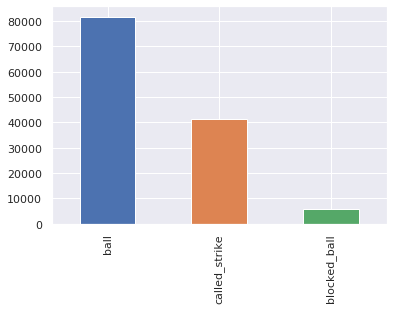

In [16]:
baseball['description'].value_counts().plot(kind = 'bar')

## POINT 1: 
Blocked ball is the same thing as a ball, so we can group those classes together

## Look at predictors

In [3]:
baseball.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128800 entries, 0 to 128799
Data columns (total 20 columns):
player_name          128800 non-null object
p_throws             128800 non-null object
pitch_name           128317 non-null object
release_speed        128322 non-null float64
release_spin_rate    126520 non-null float64
release_pos_x        128298 non-null float64
release_pos_y        128298 non-null float64
release_pos_z        128298 non-null float64
pfx_x                128298 non-null float64
pfx_z                128298 non-null float64
vx0                  128298 non-null float64
vy0                  128298 non-null float64
vz0                  128298 non-null float64
ax                   128298 non-null float64
ay                   128298 non-null float64
az                   128298 non-null float64
sz_top               128494 non-null float64
sz_bot               128494 non-null float64
release_extension    128315 non-null float64
description          128800 non-null 

## POINT 2: 
Some missing data. Inspecting the values, it does not appear that any one feature has a significant amount of missing. The most missing is 'release_spin_rate', which has 2280 missing instances, or 1.77% missing rows. Imputation will most likely be used to handle such missing. 

Now, inspect that categorical features.

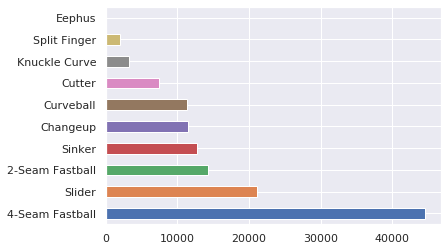

In [20]:
cat_features = ['player_name', 'p_throws', 'pitch_name']

#look at pitch_name first
baseball[cat_features[2]].value_counts().plot(kind = 'barh')

## POINT 3: 
Eephus is not needed, as it has minimal occurances. 
Knuckle Curve is the same pitch as Curveball, so those classes can be grouped together. 

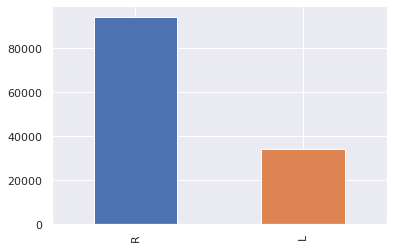

In [21]:
baseball['p_throws'].value_counts().plot(kind = 'bar')

## Nothing much to say about this feature. 

'player_name' is just all the pitcher names that we collected in the `Data_Collection.ipynb` notebook, so like 'p_throws, this feature has nothing much to tell us. 

Move on to the numeric data

## Ensure Numeric Features Quality

Here is to check that that there are no outlandish or impossible values for features. We wouldn't want to see a negative value for release_speed!

Speaking of release_speed, there appear to be some interesting values for min and max. However, those are not erroneous values; a few pitchers are now starting to throw over 100 mph; the fastest recorded pitch was roughly 106 mph by Aroldis Chapman in 2015. 

As for most other features, there are not seemingly extreme values that physcially cannot happen; outliers potentially, but not impossible values. 


In [22]:
baseball.describe().T

,count,mean,std,min,25%,50%,75%,max
release_speed,128322.0,88.669747,5.997476,56.0000,84.500000,90.10000,93.300000,104.4000
release_spin_rate,126520.0,2244.375956,310.180378,485.0000,2094.000000,2258.00000,2423.000000,3640.0000
release_pos_x,128298.0,-0.823445,1.970253,-5.0047,-2.207300,-1.57425,0.887250,4.8683
release_pos_y,128298.0,54.507866,0.505403,51.0297,54.173700,54.50165,54.835475,57.7872
release_pos_z,128298.0,5.853475,0.556212,1.7088,5.596200,5.91155,6.198900,7.4209
pfx_x,128298.0,-0.149122,0.884362,-2.4215,-0.918700,-0.23575,0.563100,2.2929
pfx_z,128298.0,0.636885,0.754510,-2.0134,0.199400,0.80170,1.240300,2.6710
vx0,128298.0,2.517938,6.221745,-20.0954,-1.642175,4.13720,7.047300,18.9980
vy0,128298.0,-128.859364,8.702818,-152.0191,-135.559200,-130.93835,-122.786725,-80.9000
vz0,128298.0,-4.267748,3.457352,-17.2848,-6.730975,-4.45855,-2.019875,11.6642


## Light EDA # MAKE SURE TO LOOK AT TARGET


This next section will perform some EDA on our features. We will follow some of the procedures described in step 3 of the Outline of Notebook section.

# ANALYSIS

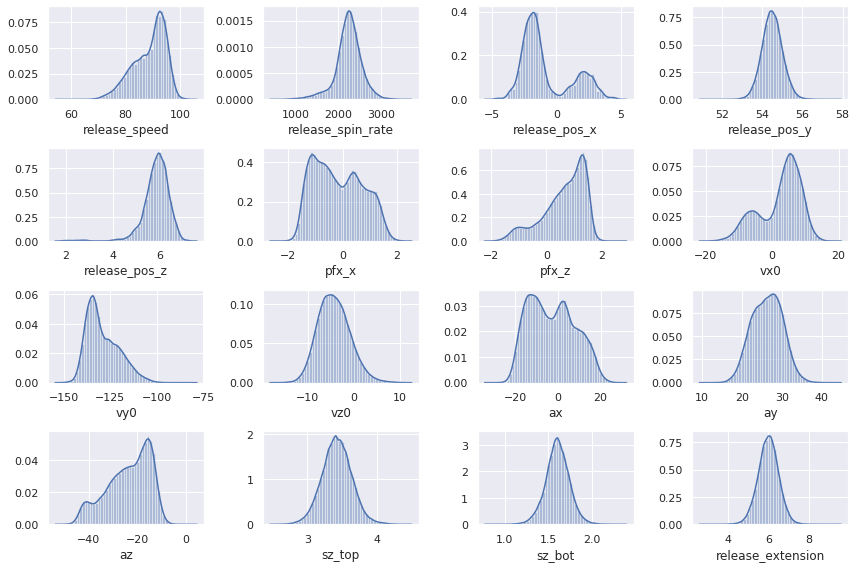

In [10]:
#visualizations

num_features_to_plot = ['release_speed', 'release_spin_rate', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'release_extension']

def plot_hist(df, features, subplot_dimensions):
    '''Input: list of feature names, list of subplot dimensions'''
    fig = plt.figure(figsize = (12, 8))
    
    for idx, feature in enumerate(list(df[features])):
        idx += 1
        plt.subplot(subplot_dimensions[0], subplot_dimensions[1], idx)
        sns.distplot(df[feature])
        idx +=1
        
        plt.tight_layout()

plot_hist(baseball, num_features_to_plot, [4,4])

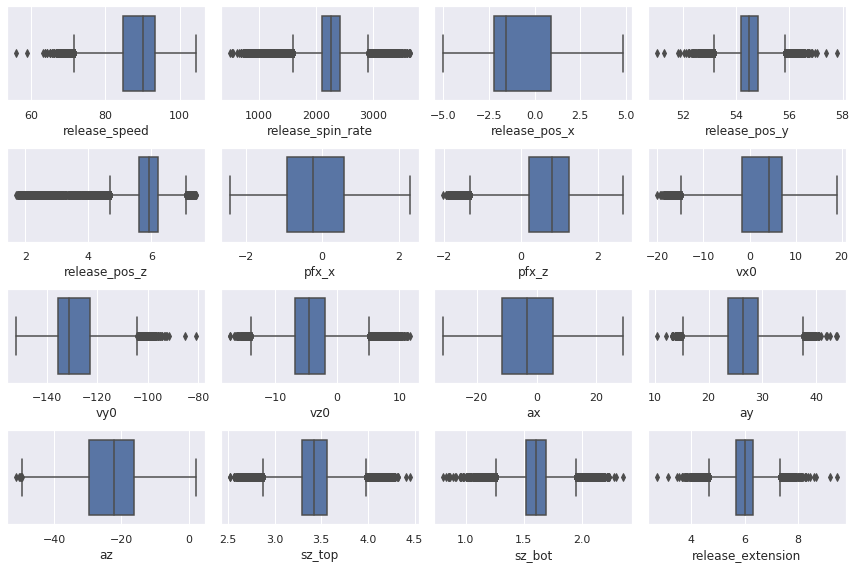

In [11]:
def plot_box(df, features, subplot_dimensions):
    '''Input: list of feature names, list of subplot dimensions'''
    fig = plt.figure(figsize = (12, 8))
    
    for idx, feature in enumerate(list(df[features])):
        idx += 1
        plt.subplot(subplot_dimensions[0], subplot_dimensions[1], idx)
        sns.boxplot(df[feature])
        idx +=1
        
        plt.tight_layout()

plot_box(baseball, num_features_to_plot, [4,4])

## MORE EDA

Bi-variate visualizations of features

Start with groups of features that have similar behavior, like features dealing with pitch release information, or a group concerned with acceleration.




In [27]:
baseball.columns

Index(['player_name', 'p_throws', 'pitch_name', 'release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'release_extension', 'description'],
      dtype='object')

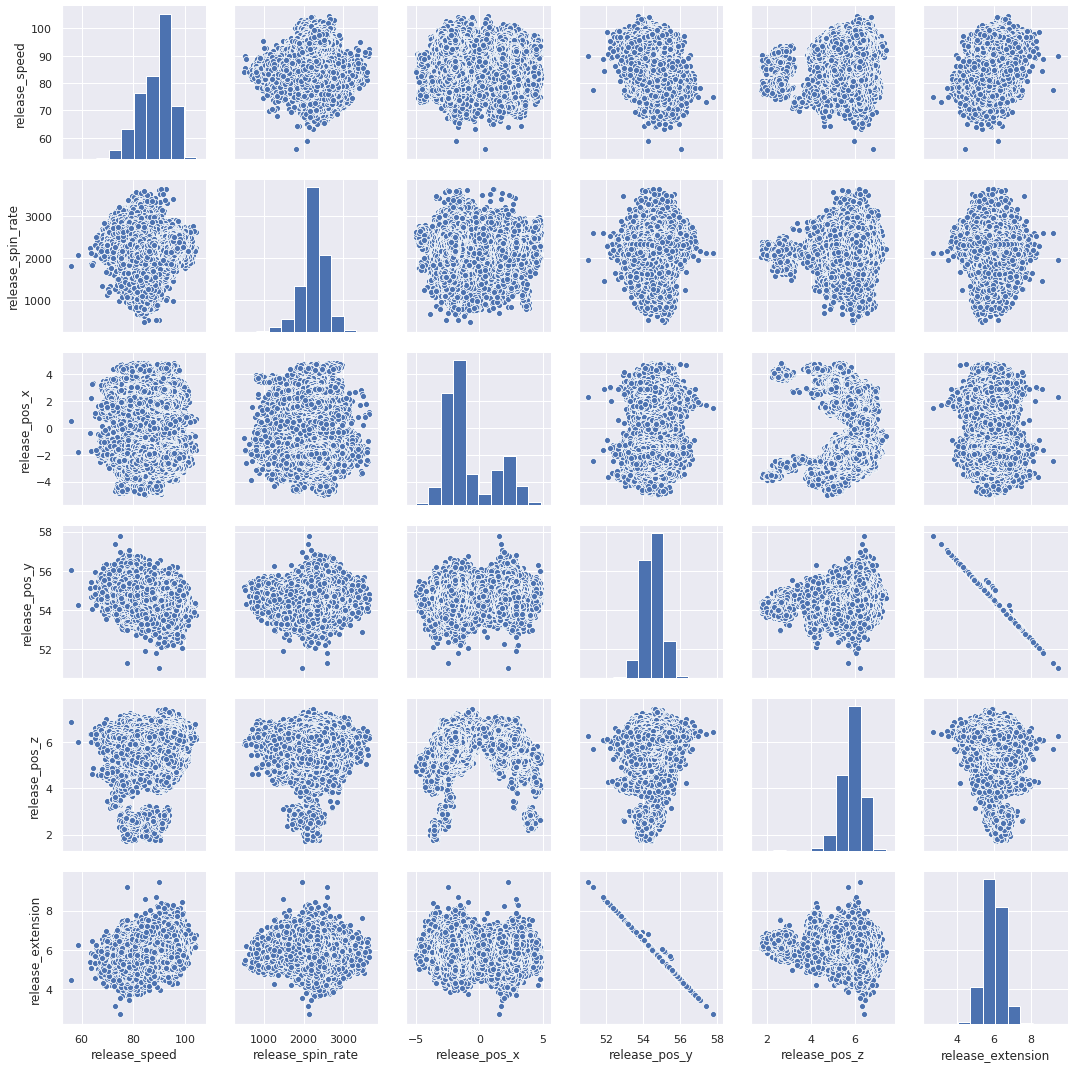

In [51]:
release_features = ['release_speed','release_spin_rate', 'release_pos_x', 
                    'release_pos_y', 'release_pos_z','release_extension',
                    ]
sns.pairplot(baseball[release_features])

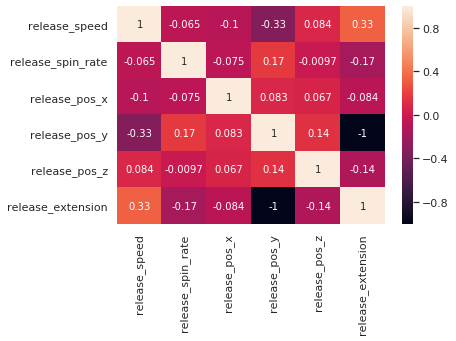

In [52]:
sns.heatmap(baseball[release_features].corr(), annot=True)

## POINT 4:
'Release_pos_y' and 'release_extenstion' perfectly correlated with each other, so only one of them needs to be used as a predictor in modeling pipelines. Other features are slightly correlated or not much at all. 

Now look at velocity and acceleration grouped features, in which all of their measurements are at y=50ft. 

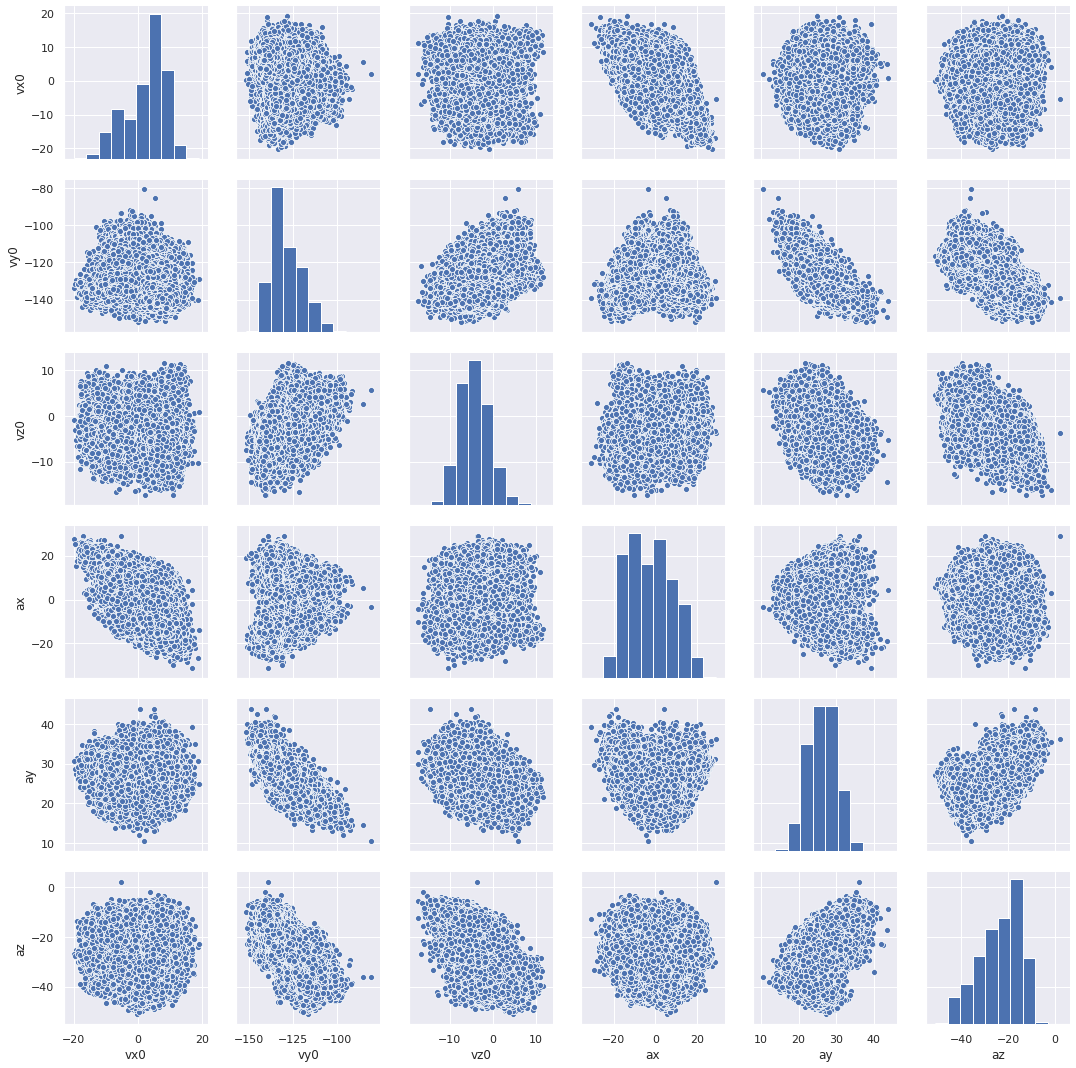

In [40]:
acc_features = ['vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']

sns.pairplot(baseball[acc_features])


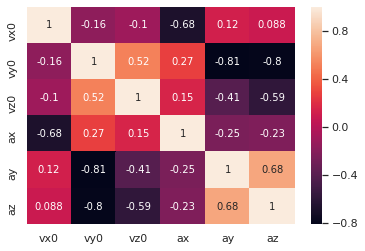

In [41]:
sns.heatmap(baseball[acc_features].corr(), annot=True)

## Point 5:

The velocity measures are strongly correlated with the acceleration features with their respective 'dimension' (x, y, or z), and vice-versa. Acceleration feautures are mildly correlated with each other, and the same holds true for the velocity features, but the velocity intercorrelation is a little less. It might be best to drop the acceleration features and let the velocity features present the information that both groups want to present. 

Build a correlation matrix based on all numeric data together, then compare with a matrix without the accerlation data, to validate if proposed idea above is appropriate.

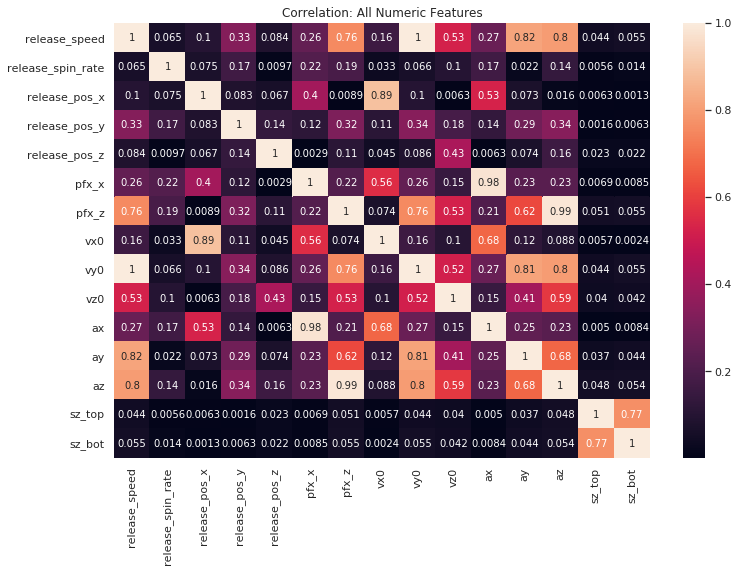

In [62]:
plt.figure(figsize = (12,8))
plt.title("Correlation: All Numeric Features")
num_features = ['release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot']

sns.heatmap(abs(baseball[num_features].corr()) , annot=True)

## 

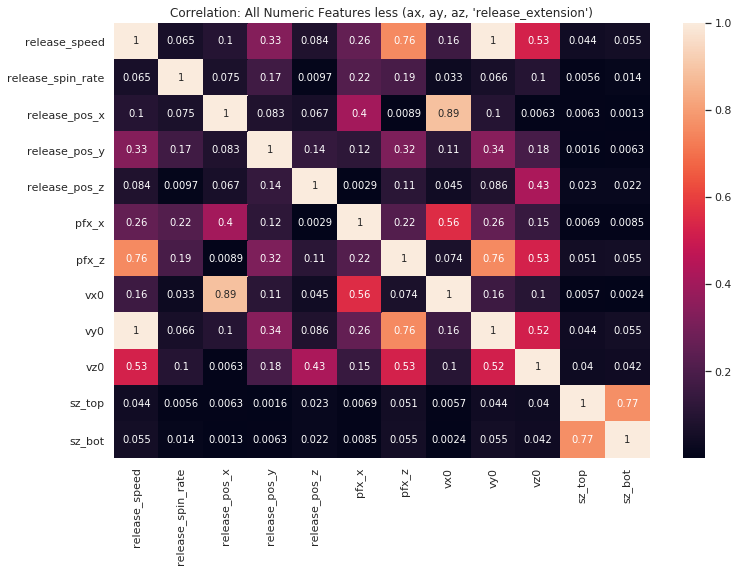

In [64]:
plt.figure(figsize = (12,8))
plt.title("Correlation: All Numeric Features less (ax, ay, az, 'release_extension')")
num_features_to_keep = ['release_speed', 
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'sz_top',
       'sz_bot']

sns.heatmap(abs(baseball[num_features_to_keep].corr()) , annot=True)
    
    

## Analysis:

There are less strongly correlated features within all the numeric features without the accerlation group fetures, ax, ay, az. Features that seem to capture similar information, vx0, vy0, vz0, in addition to pfx_x and pfx_z are less intercorrelated with other features, so excluding the acceleration group features appears to be a valid approach. 


# FINAL POINTS:

#### Target feature:
'Blocked ball' is the same thing as a 'ball', so we can group those classes together.

#### Predictors:
Some missing data. Inspecting the values, it does not appear that any one feature has a significant amount of missing. The most missing is 'release_spin_rate', which has 2280 missing instances, or 1.77% missing rows. Imputation will most likely be used to handle such missing.

#### 'Pitch_name'
'Eephus' class is not needed, as it has minimal occurances. 
'Knuckle Curve' is the same pitch as 'Curveball,' so those classes can be grouped together. 

#### Correlation Analysis
'Release_pos_y' and 'release_extenstion' perfectly correlated with each other, so only one of them needs to be used as a predictor in modeling pipelines.

#### Correlation Analysis
The velocity measures are strongly correlated with the acceleration features with their respective 'dimension' (x, y, or z), and vice-versa. Acceleration feautures are mildly correlated with each other, and the same holds true for the velocity features, but the velocity intercorrelation is a little less. It might be best to drop the acceleration features and let the velocity features present the information that both groups want to present. 

In [66]:
baseball.columns

Index(['player_name', 'p_throws', 'pitch_name', 'release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'release_extension', 'description'],
      dtype='object')

In [67]:
filtered_features_to_keep  = ['player_name', 'p_throws', 'pitch_name'  'release_speed', 
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'sz_top',
       'sz_bot']